In [0]:
import google.datalab.bigquery as bq
import numpy as np
import google.datalab.storage as storage
import pandas as pd
import matplotlib.pyplot as plt
from google.datalab import Context
from IPython.display import Image
import google.datalab.contrib.mlworkbench.commands

ImportError: ignored

In this project, I will work on the New York citibike trips dataset, aiming to analyze the bike rider behaviors. The variables I mainly focus on are starting time of the ride, start and end location of the ride (latitude&longitude), and the age of the rider(we obtain from the birth year), in order to predict trip duration.

#### query data

First I run the query, select the tripduration, time, and location variables out of the dataset, then restrict the tripduration to be from 1 minute to 1 hour, because less than 1 minute possibly means that the rider just tried on the bicycle and did not even take any ride, and more than 1 hour possibly means that the rider forgot to lock out the bicycle, which are all bad data  to analyze. Therefore, I choose to eliminate those data, as well as the data with null values. After cleaning the data, final dataframe as cycle_query is produced. 

In [0]:
%%bq query --name cycle_query
SELECT
  tripduration,
  CAST(EXTRACT(DAYOFWEEK FROM starttime) AS STRING) as weekday,
  CAST(EXTRACT(DAYOFYEAR FROM starttime) AS STRING) as day,
  CAST(EXTRACT(HOUR FROM starttime) AS STRING) as hour,
  start_station_latitude,
  start_station_longitude,
  end_station_latitude,
  end_station_longitude,
  birth_year
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE 
  tripduration >= 60.0 AND tripduration <= 3600.0 AND
  start_station_latitude IS NOT NULL AND
  start_station_longitude IS NOT NULL AND
  end_station_latitude IS NOT NULL AND
  end_station_longitude IS NOT NULL AND
  birth_year IS NOT NULL

#### sample data

Then, for the machine learning process, I choose a part of data as the training set and the other part of data as the evaluating set. Therefore, I randomly distribute all the data, and choose first 95% as the training set, and set other data to be the evaluation set.

From the messages I print, there are about 134706 instances in training set, and 7083 instances in evaluation set.

In [0]:
sampling = bq.Sampling.random(percent=0.3)
job = cycle_query.execute(sampling=sampling)
df = job.result().to_dataframe()
msk = np.random.rand(len(df)) < 0.95
train_df = df[msk]
eval_df = df[~msk]

In [0]:
print('Training set includes %d instances.' % len(train_df))
print('Eval set includes %d instances.' % len(eval_df))

Training set includes 134706 instances.
Eval set includes 7083 instances.


#### save to csv

In [0]:
!mkdir -p ./cycle

In [0]:
train_df.to_csv('./cycle/train.csv', header=False, index=False)
eval_df.to_csv('./cycle/eval.csv', header=False, index=False)

#### explore data

In [0]:
%%ml dataset create
format: csv
train: ./cycle/train.csv
eval: ./cycle/eval.csv
name: cycle_data
schema:
    - name: tripduration
      type: FLOAT
    - name: weekday
      type: STRING
    - name: day
      type: STRING
    - name: hour
      type: STRING
    - name: start_station_latitude
      type: FLOAT
    - name: start_station_longitude
      type: FLOAT
    - name: end_station_latitude
      type: FLOAT
    - name: end_station_longitude
      type: FLOAT
    - name: birth_year
      type: FLOAT

In [0]:
%%ml dataset explore --overview
name: cycle_data

train data instances: 134706
eval data instances: 7083
Sampled 1000 instances for each.


In [0]:
%%ml dataset explore --facets
name: cycle_data

train data instances: 134706
eval data instances: 7083
Sampled 1000 instances for each.


Before the data is used, I first explored the dataset with one over view and one facets view. I found in our training data, there is no missing values. For the two variables about longitude, the data is slightly left skewed. For trip duration, the data lays heavily to the left. For birthyear, the data lays to the right. I then explored the relationship between variables using the facets view function. 

#### analyze data

In [0]:
!rm -r -f ./cycle/analysis

In [0]:
%%ml analyze
output: ./cycle/analysis
data: $cycle_data
features:
  tripduration:
    transform: target   
  weekday:
    transform: one_hot
  day:
    transform: one_hot
  hour:
    transform: one_hot
  start_station_latitude:
    transform: scale    
  start_station_longitude:
    transform: scale
  end_station_latitude:
    transform: scale
  end_station_longitude:
    transform: scale
  birth_year:
    transform: scale

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/notebooks/cycle/train.csv...
file /content/datalab/notebooks/cycle/train.csv analyzed.


I then analyzed the data for the requested transformations. In this step, I built vocabulary for categorical features, and created numeric scales for numeric features. My target is tripduration and we included all the columns in the dataset for analysis. 

#### transform data

In [0]:
!rm -r -f ./cycle/transform

In [0]:
%%ml transform
output: ./cycle/transform
analysis: ./cycle/analysis
data: $cycle_data

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/envs/py2env/lib/python2.7/site-packages/scipy/optimize/_minimize.py:32: ImportWarning: Not importing directory '/usr/local/envs/py2env/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb
/usr/local/envs/py2env/lib/python2.7/site-packages/scipy/spatial/__init__.py:95: ImportWarning: Not importing directory '/usr/local/envs/py2env/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *
/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future,

In [0]:
%%ml dataset create
format: transformed
name: cycle_transformed_data
train: ./cycle/transform/train-*
eval: ./cycle/transform/eval-*

In [0]:
%%ml dataset explore
name: cycle_transformed_data

train data instances: 134706
eval data instances: 7083


I think it is necessary to include the transform step for the training and evalulation data. By doing this, I can speed up training time to allow training to start from preprocessed data. 

#### training

In [0]:
!rm -r -f ./cycle/linear_train # Delete previous runresults 
!rm -r -f ./cycle/dnn_train 

#### Linear regression model

Linear regression model gives a baseline for how a linear prediction of duration using the covariates would be. Previous training results were firstly deleted, and then I used the train function of ml workbench with a model type defined as linear regression. I also used the model built from the transformed data to make sure I used the correct data to learn. Next, I took the output of the training and used the summary function from the ml package to produce an analysis of each step in the learning process. Finally, I plot the loss of the training and evaluation data to observe the trend.

I needed to specify a max step and learning rate for the linear model. For the learning rate, I decided to use 0.1 in order to achieve quick but accurate learning, since a smaller rate would have taken a much longer time to generate in the model. I then chose a max step of 30,000 so that the model would have time to generate a decent prediction while also not running for a long time.

 From the plot below, I observed the actual loss from the evaluation function. The numbers given are in seconds, and they reflect how far off our model is from the actual time. In other words, the plot indicates the difference between the true length of a person's bike ride and the length of the bike ride predicted by our linear model. I observed that that the loss does not drop at a significant rate in the early steps, and decreases gradually over time.The minimum loss for the linear function is just under 600,000. This is a very large loss, and shows that a linear model does not perform well at predicting ride time.

In [0]:
%%ml train
output: ./cycle/linear_train
analysis: ./cycle/analysis
data: $cycle_transformed_data
model_args:
    model: linear_regression
    learning-rate: 0.1
    max-steps: 30000

TensorBoard was started successfully with pid 13225. Click here to access it.

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [0]:
from google.datalab.ml import Summary

summary = Summary('./cycle/linear_train')

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


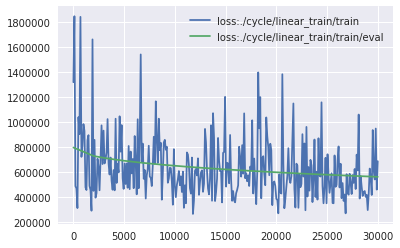

In [0]:
summary.plot('loss')

#### DNN regression model

The second step of my model is to create a feed-forward neural network, which gives an actual training. I used the transformed data to construct the neural network. Next, I took the output of the training and used the summary function from the ml package to produce an analysis of each step in the learning process. Finally, I plotted the loss of the training and evaluation data to observe the trend.

Here, I didn't specify a learning rate or step size. This means the model will run until the eval loss is no longer decreasing. Next, I defined the number of hidden layers and nodes for the neural network to use. The first argument specifies the number of hidden layers, which I set at 200. The second argument specifies the number of nodes in each layer, which I set at 100. After performing a few different trials with different numbers of hidden layers and nodes, I found that 200 and 100 were performing the best and decided to use them in our final evalutation.

From the plot below, I obtained the actual loss from the evaluation data. The numbers given are in seconds, and they reflect how far off the model is from the actual time. In other words, this plot tells me the difference between the true length of a person's bike ride and the length of the bike ride predicted by the FNN model. I see that the loss drops at a significant rate in the early steps, and stops decreasing around 5,000 steps in. The minimum loss for the linear function is about 250,000. This is a significantly lower loss than the linear model, resulting in a model that performs better at predicting the number of seconds a bike is used.

In [0]:
%%ml train
output: ./cycle/dnn_train
analysis: ./cycle/analysis
data: $cycle_transformed_data
model_args:
    model: dnn_regression
    hidden-layer-size1: 200
    hidden-layer-size2: 100

TensorBoard was started successfully with pid 23316. Click here to access it.

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


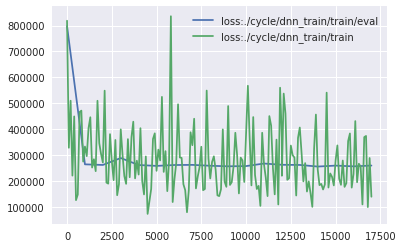

In [0]:
summary = Summary('./cycle/dnn_train')
summary.plot('loss')

#### batch prediction

 The final step of this model is batch prediction, which tells me how accurate the model is. I first delete the previous training results, and then I used the batch-predict function of ml workbench. The model built from our training data was used, but the actual data I input is the evaluation data. This allows me to test the neural network on data that is different from the data I used to build the network. Therefore, this network can't just memorize results from the training data; it must use what its learned from the training data to attempt to predict the evaluation data. The final step of the batch prediction is to output a regression, so I can determine the model's accuracy.

 The regression gives the errors as seen below. The numbers given are in seconds, and they reflect how far off our model is in different ranges. In other words, the batch prediction regression tells me the difference between the true length of a person's bike ride and the length of the bike ride predicted by our model. The first number I looked at was 90% absolute error. This number tells me that 90% of our model's predictions are within about 757 seconds or 12 minutes and 37 seconds of the true duration of the bike ride. This isn't the best accuracy, but it's not bad given the sample size I used and the number of nodes and hidden layers.

I also looked at the mean absolute error, which reflects better accuracy than our 90% absolute error. From this number, I learnt the average magnitude of our errors, which is about 387 seconds. In other words, the mean absolute error says on average, the model's predictions are withing 387 seconds or 6 minutes and 27 seconds of the true values of bike ride duration.

 Overall, this model was relatively accurate. Had I trained it with more data, it would likely output even better predictions, but given the sample size, I was able to find a neural network that fit our data within decent error bounds.

In [0]:
!rm -r -f ./cycle/batch_predict # Delete previous results.
!ls ./cycle/dnn_train/

evaluation_model  model  schema_without_target.json  train


In [0]:
%%ml batch_predict
model: ./cycle/dnn_train/evaluation_model/
output: ./cycle/batch_predict
format: csv
data:
  csv: ./cycle/eval.csv 

local prediction...
INFO:tensorflow:Restoring parameters from ./cycle/dnn_train/evaluation_model/variables/variables
done.


In [0]:
!ls ./cycle/batch_predict

predict_results_eval.csv  predict_results_schema.json


In [0]:
%%ml evaluate regression
csv: ./cycle/batch_predict/predict_results_eval.csv

,metric,value
0,Root Mean Square Error,510.299826
1,Mean Absolute Error,387.046742
2,50 Percentile Absolute Error,319.145600
3,90 Percentile Absolute Error,756.775000
4,99 Percentile Absolute Error,1659.440600


In [0]:
jupyter nbconvert to html notebook.ipynb

SyntaxError: ignored

*italicized text*#### conclusion

My attempt to build a neural network that predicts bike ride duration was both succesful and a great learning experience. To reiterate, I chose input variables that I thought would be most predictive of ride duration: weekday, day, hour, birth year of rider, beginning longitude and latitude, and ending longitude and latitude. I then sampled our dataset and turned it into a csv file. I divided the data into a training set-- with enough rows to build an accurate model but not so big it used up a ton of computing credits--and a test set so I could evaluate the accuracy of our model. I then followed the approate ml workbench steps to build and train the model: explore, analyze, transform, and train using both a linear regression model and a more sophisticated deep neural network model. Finally, I tested the model on the evalutation data and learned its accuracy.

In class, I learned about the Universality Theorem, which essentially states that any measurable and bounded function can be described by a neural network within an arbitrary error approximation. In the context of our project, I wanted to describe the relationship between bike ride duration and the variables listed above using a neural network. And, I wanted to minimize the error of our neural network while operating withing the limits of our computing power, which prompted my decisions for sample size, number of nodes and hidden layers, and learning rate.
  
 Ultimately, I was able to build a model that predicts the duration of bike trips within an average of about 387 seconds of the true duration of the bike trip. This result shows that not only were my decisions of sample size, number of nodes and hidden layers, and learning rate are good decisions, but also that the variables  I chose to look at are good predictors of bike ride duration. Moving forward, I will be able to use what I've learned from this project to build more accurate and more efficient prediction models. But more importantly, I can now predict the approximate length of your bike ride based on your age, starting location, and time of day!

